In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
%matplotlib inline

In [118]:
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    ax.grid(False)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Analysis

In [15]:
# Prepare data
demographic = pd.read_csv('../data/processed/demographic.csv')
severity = pd.read_csv('../data/processed/severity.csv', index_col=0)
features = demographic.columns 
X = demographic.astype(np.float64)
y = (severity >= 4).sum(axis=1)

In [16]:
needs_to_label = {0:'no needs', 1:'low_needs', 2:'moderate needs', 3:'high needs', 4:'very high needs'}
labels = ["no needs", "low needs", "moderate needs", "high needs", "very high needs"]
severity_to_needs = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4}
y = np.array([severity_to_needs[i] for i in y])
# Color vector, for illustration purposes
colors = {0:'b', 1:'r', 2:'g', 3:'c', 4:'y'}
y_c = np.array([colors[i] for i in y])

### Class Balance

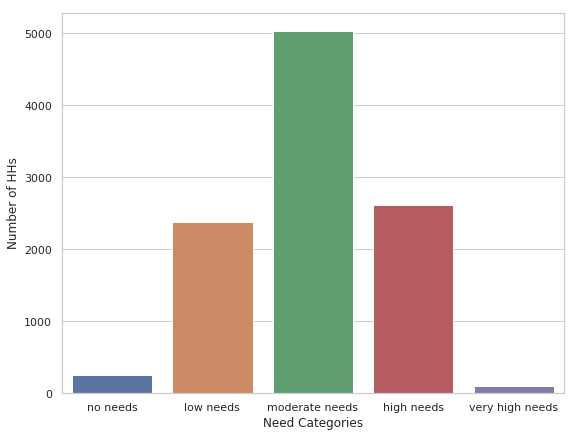

In [17]:
categories, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(figsize=(9, 7))
sb.set(style="whitegrid")
sb.barplot(labels, counts, ax=ax, tick_label=labels)
ax.set(xlabel='Need Categories',
       ylabel='Number of HHs');

Heavy class imbalances. Use appropriate scoring metrics/measures.

## Built-in imbalanced learning

In [18]:
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [20]:
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({2: 4025, 3: 2094, 1: 1900, 0: 202, 4: 81})
Testing target statistics: Counter({2: 1007, 3: 523, 1: 475, 0: 51, 4: 20})


### Balanced Bagging

In [21]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [22]:
bagging = BaggingClassifier(n_estimators=100, random_state=0, n_jobs=-1)
bagging.fit(X_train, y_train)
y_pred_bc = bagging.predict(X_test)

In [23]:
balanced_bagging = BalancedBaggingClassifier(n_estimators=100, random_state=0,
                                             n_jobs=-1)
balanced_bagging.fit(X_train, y_train)
y_pred_bbc = balanced_bagging.predict(X_test)

Bagging classifier performance:
Balanced accuracy: 0.25 - Geometric mean 0.00
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.25      0.08      0.99      0.12      0.28      0.07        51
      low needs       0.32      0.24      0.85      0.28      0.45      0.19       475
 moderate needs       0.49      0.64      0.38      0.56      0.49      0.25      1007
     high needs       0.39      0.29      0.84      0.33      0.50      0.23       523
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        20

    avg / total       0.42      0.44      0.62      0.42      0.47      0.23      2076

Balanced Bagging classifier performance:
Balanced accuracy: 0.38 - Geometric mean 0.37
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.08      0.51      0.86      0.15      0.66      0.42        51


/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


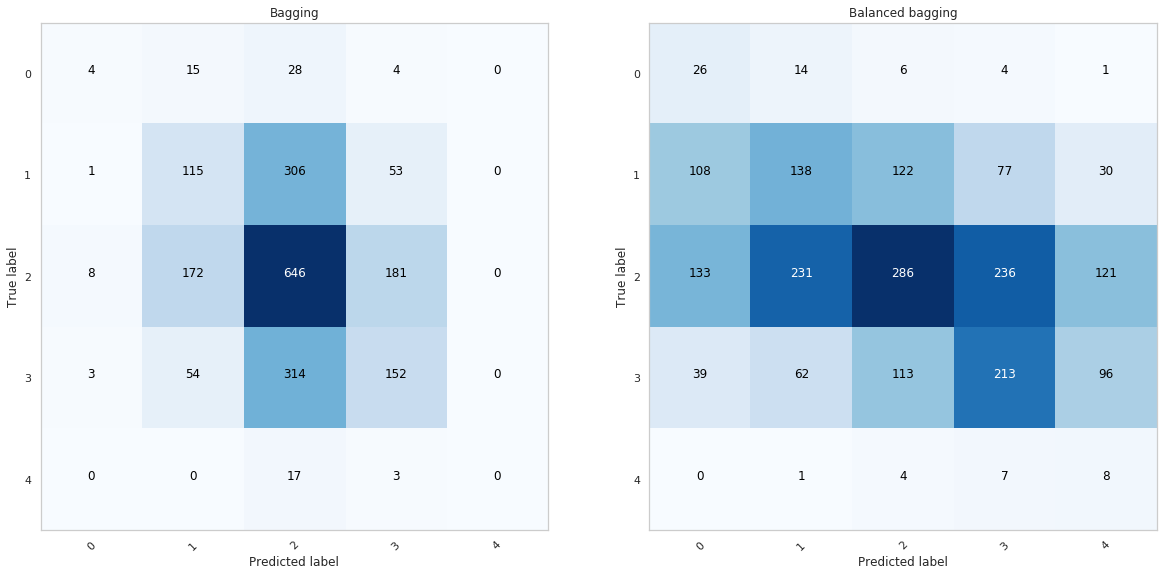

In [121]:
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_bc, target_names=labels))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_confusion_matrix(cm_bagging, classes=np.unique(y), ax=ax[0],
                      title='Bagging')


print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_bbc, target_names=labels))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(y),
                      ax=ax[1], title='Balanced bagging')

### Random Forests

In [25]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1, 
                            class_weight="balanced_subsample")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [27]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0,
                                     n_jobs=-1)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)

Random Forest classifier performance:
Balanced accuracy: 0.25 - Geometric mean 0.00
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.19      0.06      0.99      0.09      0.24      0.05        51
      low needs       0.33      0.22      0.87      0.26      0.43      0.18       475
 moderate needs       0.50      0.71      0.33      0.58      0.48      0.24      1007
     high needs       0.41      0.25      0.88      0.31      0.47      0.21       523
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        20

    avg / total       0.43      0.46      0.62      0.42      0.46      0.21      2076

Balanced Random Forest classifier performance:
Balanced accuracy: 0.42 - Geometric mean 0.38
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.09      0.63      0.83      0.15      0.72      0.5

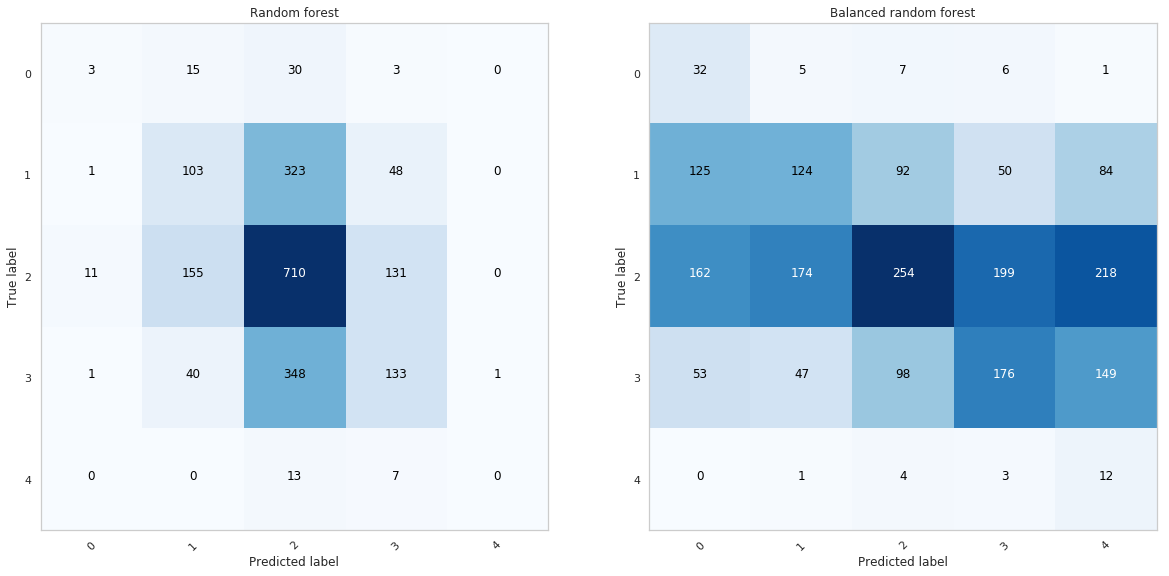

In [122]:
print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_rf, target_names=labels))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_confusion_matrix(cm_rf, classes=np.unique(y), ax=ax[0],
                      title='Random forest')

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_brf, target_names=labels))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(y), ax=ax[1],
                      title='Balanced random forest')

### Boosting

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

In [96]:
base_estimator = DecisionTreeClassifier()

In [103]:
eec = EasyEnsembleClassifier(n_estimators=100,
                             base_estimator=base_estimator,
                             n_jobs=-1)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)

In [104]:
rusboost = RUSBoostClassifier(n_estimators=100,
                              base_estimator=base_estimator)
rusboost.fit(X_train, y_train)
y_pred_rusboost = rusboost.predict(X_test)

Easy ensemble classifier performance:
Balanced accuracy: 0.42 - Geometric mean 0.38
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.08      0.63      0.82      0.15      0.72      0.51        51
      low needs       0.34      0.28      0.84      0.30      0.48      0.22       475
 moderate needs       0.55      0.24      0.81      0.33      0.44      0.18      1007
     high needs       0.42      0.33      0.84      0.37      0.53      0.27       523
very high needs       0.03      0.60      0.79      0.05      0.69      0.47        20

    avg / total       0.45      0.28      0.83      0.33      0.48      0.22      2076

RUSBoost classifier performance:
Balanced accuracy: 0.24 - Geometric mean 0.00
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.13      0.18      0.97      0.15      0.41      0.16        51
  

/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


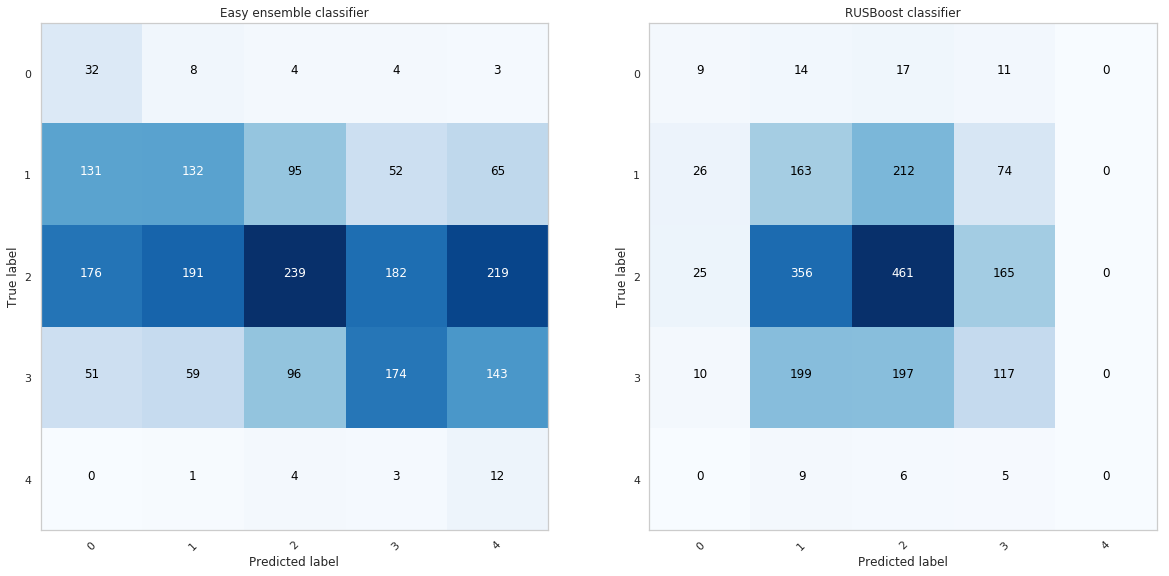

In [123]:
print('Easy ensemble classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_eec),
              geometric_mean_score(y_test, y_pred_eec)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_eec, target_names=labels))
cm_eec = confusion_matrix(y_test, y_pred_eec)
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_confusion_matrix(cm_eec, classes=np.unique(y), ax=ax[0],
                      title='Easy ensemble classifier')
print('RUSBoost classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rusboost),
              geometric_mean_score(y_test, y_pred_rusboost)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_rusboost, target_names=labels))
cm_rusboost = confusion_matrix(y_test, y_pred_rusboost)
plot_confusion_matrix(cm_rusboost, classes=np.unique(y),
                      ax=ax[1], title='RUSBoost classifier')
plt.show()

## Under/Over Sampling Pipeline

In [75]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTENC

In [76]:
cat_idx = np.where(demographic.dtypes != np.float)[0]

In [79]:
oversample = SMOTENC(categorical_features=cat_idx)
undersample = NeighbourhoodCleaningRule()
classify = LogisticRegression(multi_class='ovr', 
                            solver='liblinear')

In [80]:
pipeline = make_pipeline(oversample, undersample, classify)

In [81]:
pipeline.fit(X_train, y_train)
y_pred_pipe = pipeline.predict(X_test)

Pipe classifier performance:
Balanced accuracy: 0.37 - Geometric mean 0.26
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.08      0.47      0.86      0.13      0.64      0.39        51
      low needs       0.28      0.46      0.65      0.35      0.55      0.29       475
 moderate needs       0.48      0.03      0.97      0.05      0.17      0.03      1007
     high needs       0.38      0.59      0.68      0.46      0.63      0.39       523
very high needs       0.05      0.30      0.94      0.08      0.53      0.26        20

    avg / total       0.40      0.28      0.82      0.23      0.39      0.19      2076



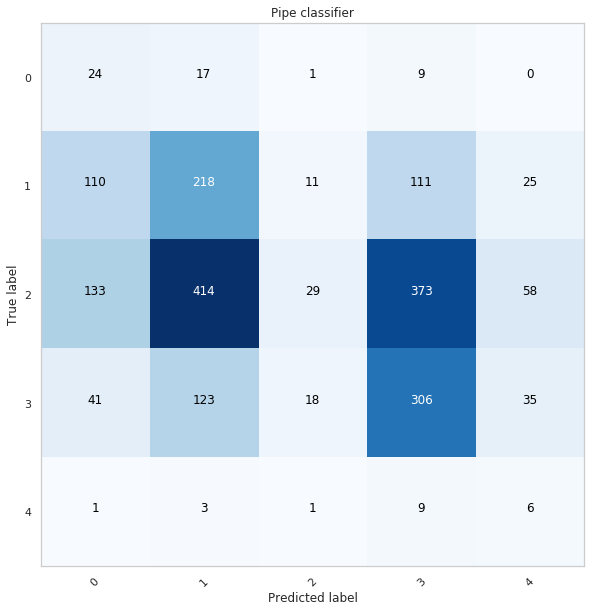

In [124]:
print('Pipe classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_pipe),
              geometric_mean_score(y_test, y_pred_pipe)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_pipe, target_names=labels))
cm_pipe = confusion_matrix(y_test, y_pred_pipe)
fig, ax = plt.subplots(figsize=(20,10))
plot_confusion_matrix(cm_pipe, classes=np.unique(y), ax=ax,
                      title='Pipe classifier')

### GridSearchCV

In [114]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import VotingClassifier

In [115]:
base_estimator = DecisionTreeClassifier()
cv_ = StratifiedKFold(3)
bclf1 = BalancedBaggingClassifier()
bclf2 = BalancedRandomForestClassifier()
bclf3 = EasyEnsembleClassifier(base_estimator)
vote = VotingClassifier(estimators=[('bbf', bclf1), ('brf', bclf2), ('eec', bclf3)], voting='hard')

In [116]:
params = {'bbf__n_estimators':[100, 400],
          'brf__n_estimators':[100, 300], 'brf__max_depth': [3, 5, 7], 
          'eec__n_estimators':[100, 200, 500]
         }

grid = GridSearchCV(estimator=vote, param_grid=params, cv=cv_, 
                    verbose=3, n_jobs=-1, scoring='balanced_accuracy')

In [117]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 26.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('bbf',
                                                     BalancedBaggingClassifier(base_estimator=None,
                                                                               bootstrap=True,
                                                                               bootstrap_features=False,
                                                                               max_features=1.0,
                                                                               max_samples=1.0,
                                                                               n_estimators=10,
                                                                               n_jobs=1,
                                                                               oob_score=False,
                                         

In [119]:
y_pred_grid = grid.predict(X_test)

Voting classifier performance:
Balanced accuracy: 0.38 - Geometric mean 0.37
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.08      0.65      0.81      0.14      0.72      0.52        51
      low needs       0.35      0.30      0.84      0.33      0.50      0.24       475
 moderate needs       0.58      0.28      0.81      0.37      0.47      0.21      1007
     high needs       0.42      0.35      0.84      0.38      0.54      0.28       523
very high needs       0.02      0.35      0.84      0.04      0.54      0.28        20

    avg / total       0.47      0.31      0.82      0.36      0.50      0.24      2076



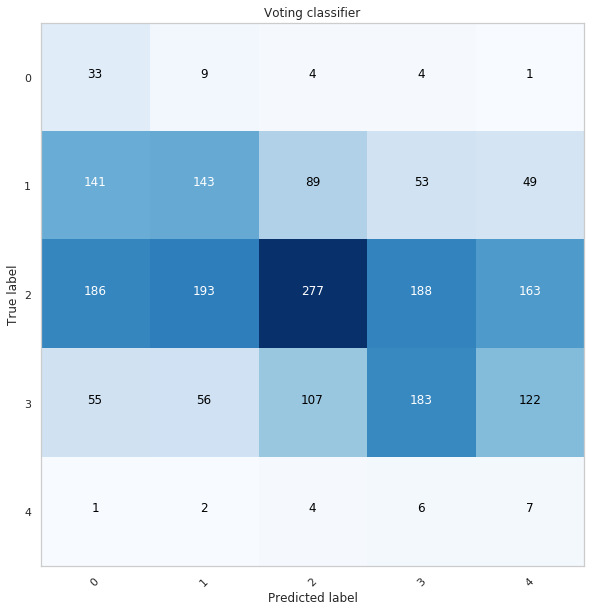

In [120]:
print('Voting classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_grid),
              geometric_mean_score(y_test, y_pred_grid)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_grid, target_names=labels))
cm_grid = confusion_matrix(y_test, y_pred_grid)
fig, ax = plt.subplots(figsize=(20,10))
plot_confusion_matrix(cm_grid, classes=np.unique(y), ax=ax,
                      title='Voting classifier')

In [126]:
grid.best_params_

{'bbf__n_estimators': 400,
 'brf__max_depth': 5,
 'brf__n_estimators': 300,
 'eec__n_estimators': 200}